# Variational Autoencoder (VAE)

In [1]:
import math
import numpy as np
from gymnasium.utils import seeding
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import cv2

CHECKPOINTS = 12
SCALE       = 6.0
TRACK_RAD   = 900/SCALE
TRACK_TURN_RATE = 0.31
TRACK_DETAIL_STEP = 21/SCALE
PLAYFIELD   = 2000/SCALE # Game over boundary

IMG_SIZE = 32  # Pixels

np_random, seed = seeding.np_random(7)

pygame 2.5.1 (SDL 2.28.2, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from gym_multi_car_racing import bezier

def get_track(control_points=None, mindst=0.08, np_random=np_random):
    if control_points is not None:
        a = np.array(control_points)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)
    else:
        a = bezier.get_random_points(n=12, scale=PLAYFIELD, mindst=mindst, np_random=np_random) // 30 * 30
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)

    x, y = np.clip(0, x.max(), x), np.clip(0, y.max(), y)

    return a, x, y

In [3]:
def plot_track(track, checkpoints=None):
    # Plot track
    plt.plot(track[:,1], track[:,0], linewidth=9, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            y, x = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

## Generate tracks

In [4]:
def get_image(coordinates, img_size=(32,32)):
    max_value = 330 if coordinates.max() < 330 else coordinates.max()

    if coordinates[:,0].min() < 0:
        coordinates[:,0] = coordinates[:,0] - coordinates[:,0].min()
    if coordinates[:,1].min() < 0:
        coordinates[:,1] = coordinates[:,1] - coordinates[:,1].min()
    coordinates = coordinates // (max_value/(img_size[0]-1))
    coordinates = coordinates.astype(np.int32)

    # Clip to 0-31
    coordinates = np.clip(coordinates, 0, img_size[0]-1)
    
    img = np.zeros(img_size)

    for i in range(coordinates.shape[0]):
        img[coordinates[i,1], coordinates[i,0]] = 1

    return img

In [5]:
from PIL import Image, ImageDraw
import numpy as np

def get_image_(points, img_size=(32, 32)):
    """
    Create a 2D image of a curve using a set of points.

    Parameters:
    - points: List of tuples representing (x, y) coordinates of the curve.
    - img_size: Tuple representing the size of the image (width, height).

    Returns:
    - img_array: NumPy array representing the image.

    Example:
    >>> points = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16)]
    >>> image_array = get_image(points)
    """
    # Find the bounding box of the points
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    # Create a blank image with a black background
    width = int(max_x - min_x) + 20
    height = int(max_y - min_y) + 20
    image = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(image)

    # Translate points to the image coordinates
    translated_points = [(x - min_x + 10, y - min_y + 10) for x, y in points]

    # Draw the curve on the image
    draw.line(translated_points, fill="white", width=2)

    # Convert the PIL image to a NumPy array
    img_array = np.array(image)

    # Convert to grayscale
    img_array = np.mean(img_array, axis=2)

    # Resize image
    width, height = img_size
    img_array = cv2.resize(img_array, dsize=(width, height), interpolation=cv2.INTER_AREA)

    # Normalize pixel values
    img_array = img_array / img_array.max()

    return img_array

Calculate track complexity using the function taken from the dcd repository.

In [6]:
import math
import os
import pandas as pd
import geopandas as gpd
import shapely


def get_notches(poly):
    """
    Determine the number of notches in a polygon object and calculate 
    normalized notches of polygon
    
    Based on: 
        "Measuring the Complexity of Polygonal Objects" 
        (Thomas Brinkhoff, Hans-Peter Kriegel, Ralf Schneider, Alexander Braun)
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.73.1045&rep=rep1&type=pdf
        
        https://github.com/pondrejk/PolygonComplexity/blob/master/PolygonComplexity.py
        
    @poly (Shapely Polygon object)
    
    Returns normalized notches
    """
    notches = 0 
    coords = list(poly.exterior.coords)
    for i, pt in enumerate(coords[:-1]):
        x_diff = coords[i+1][0] - pt[0]
        y_diff = coords[i+1][1] - pt[1]
        angle = math.atan2(y_diff, x_diff)
        if angle < 0: 
            angle += 2*math.pi
        if angle > math.pi:
            notches += 1
    
    if notches != 0:
        notches_norm = notches / (len(coords)-3)
    else:
        notches_norm = 0 
        
    return notches_norm

def get_stats(gdf, coeff_ampl, coeff_conv):
    """
    Get polygon's amplitude of vibration:
    
    ampl(pol) = (boundary(pol) - boundary(convexhull(pol))) / boundary(pol)
    
    Get deviation from convex hull:
    conv(pol) = (area(convexhull(pol)) - area(pol)) / area(convexhull(pol))
    
    Measure complexity
    
     Based on: 
        "Measuring the Complexity of Polygonal Objects" 
        (Thomas Brinkhoff, Hans-Peter Kriegel, Ralf Schneider, Alexander Braun)
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.73.1045&rep=rep1&type=pdf
        
        https://github.com/pondrejk/PolygonComplexity/blob/master/PolygonComplexity.py
    
    Get area, centroid, distance from each others, boudary, convex hull, 
    perimeter, number of vertices.
    
    Returns tuple with dict of stats values and GeoDataframe with stats
    """
    nb = gdf['geometry'].count()
    gdf['area'] = gdf['geometry'].area
    tot_area = gdf['area'].sum()
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['boundary'] = gdf['geometry'].boundary
    gdf['convex_hull'] = gdf['geometry'].convex_hull
    gdf['convex_boundary'] = gdf['geometry'].convex_hull.boundary
    gdf['convex_area'] = gdf['geometry'].convex_hull.area
    gdf['nbvertices'] = gdf['geometry'].apply(lambda x: len(list(x.exterior.coords)))
    gdf['notches'] = gdf['geometry'].apply(lambda x: get_notches(x))
    
    gdf['amplitude'] = gdf.apply(
            lambda x:(
                    x['boundary'].length - x['convex_boundary'].length
                    ) / (x['boundary'].length + 1e-3), 
                    axis=1)
    gdf['convex'] = gdf.apply(
            lambda x: (
                    x['convex_area'] - x['area']
                    ) / (x['convex_area'] + 1e-3),
                    axis=1)
    gdf['complexity'] = gdf.apply(
            lambda x: coeff_ampl*x['amplitude'] * x['notches'] + coeff_conv * x['convex'],
            axis=1
            )
    
    mean_amplitude = gdf['amplitude'].mean()
    mean_convex = gdf['convex'].mean()
    mean_norm_notches = gdf['notches'].mean()
    mean_complexity = gdf['complexity'].mean()
    
    gdf['perimeter'] = gdf['geometry'].length
    tot_perimeter = gdf['perimeter'].sum()
    
    if ("lat" in gdf.columns) or ("lon" in gdf.columns):
        columns_drop = ["boundary", "convex_hull", "convex_boundary", "convex_area", "centroid", "lat", "lon"]
    else:
        columns_drop = ["boundary", "convex_hull", "convex_boundary", "convex_area", "centroid"]
    gdf = gdf.drop(columns_drop, axis=1)
    
    gdf = gdf.reset_index()
    
    if nb > 1:
        gdf = gdf.sort_values(by='perimeter', ascending=False)
        gdf = gdf.iloc[[0]]
    
    return {
        'area':tot_area,
        'perimeter':tot_perimeter,
        'amplitude': mean_amplitude,
        'convex': mean_convex,
        'notches': mean_norm_notches,
        'complexity': mean_complexity
    }, gdf
            
def complexity(points, coeff_ampl=0.8, coeff_conv=0.2):
    polygon = shapely.geometry.Polygon(points)
    gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([polygon]))
    dict_complexity, gdf = get_stats(gdf, coeff_ampl, coeff_conv)        

    return dict_complexity

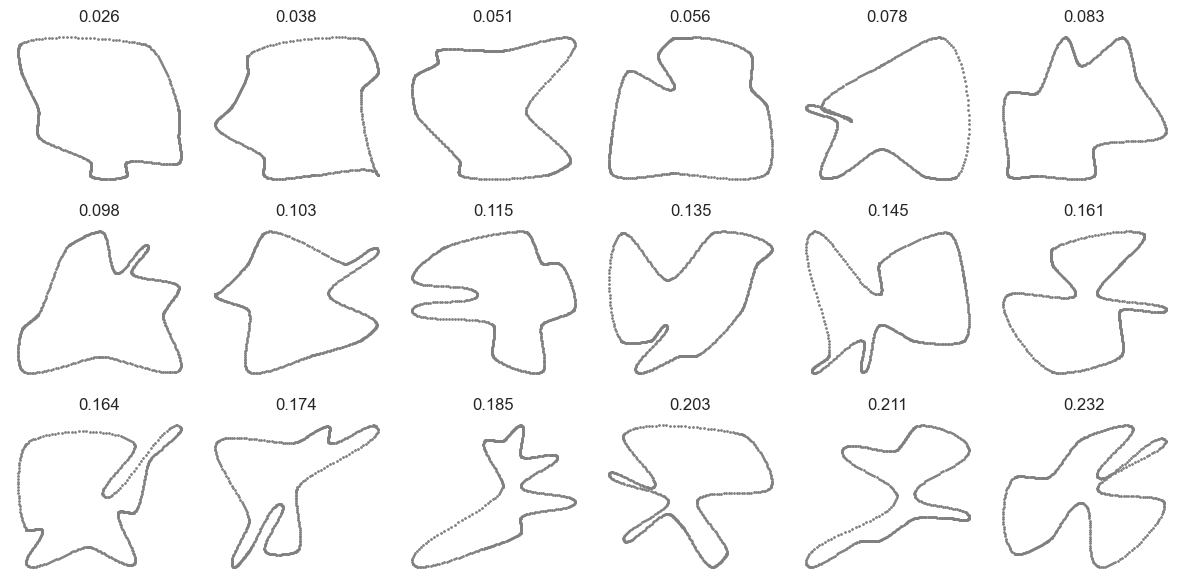

In [84]:
complexities = []
points = []
convexities = []
notches = []

# Complexities
comps = np.linspace(0.02, 0.22, num=18)
# Add one more element to the array
comps = np.append(comps, 0.5)

for i in range(18):
    comp = 1
    while (comp < comps[i] or comp > comps[i+1]):
        control_points, x, y = get_track(np_random=np_random)
        p = np.array(list(zip(x, y)))
        comp = complexity(p)['complexity']

    complexities.append(comp)
    convexities.append(complexity(p)['convex'])
    notches.append(complexity(p)['notches'])
    points.append(p)

# Sort by complexity
complexities = np.array(complexities)
idx = np.argsort(complexities)
complexities = complexities[idx]
points = np.array(points)[idx]

plt.figure(figsize=(12,6))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.scatter(points[i][:,0], points[i][:,1], color="gray", s=1)
    title = f"{np.round(complexities[i], 3)}" #\nconv: {np.round(convexities[i], 3)}\nnotches: {np.round(notches[i], 3)}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()

In [85]:
X = np.load("X.npy")

In [ ]:
complexities = []

for i in range(X.shape[0]):
    control_points, x, y = get_track(X[i]*30, np_random=np_random)
    p = np.array(list(zip(x, y)))
    complexities.append(complexity(p)['complexity'])

    print(f"Progress: {i+1}/{X.shape[0]}", end="\r")

In [ ]:
complexities = np.array(complexities)
np.save("complexities.npy", complexities)

Generate random tracks

In [ ]:
NUM_TRACKS = 50_000
IMG_SIZE = (12,12)

X = []  # Track control points
Y = []  # Track complexity

for i in range(NUM_TRACKS):
    print(f"Generating track {i+1}/{NUM_TRACKS}", end="\r")
    # Generate random track
    checkpoints, x, y = get_track(np_random=np_random)
    X.append(checkpoints)
    # Get image from track
    track = np.array([x, y]).T
    Y.append(complexity(track)['complexity'])
    #Y.append(get_image_(track, img_size=IMG_SIZE))

X = np.array(X).astype(np.float32) // 30  # Scale down to 0-11
Y = np.array(Y).astype(np.float32)

X.shape, Y.shape

((50000, 12, 2), (50000,))

Generate random tracks with a uniform distribution of complexity

In [ ]:
# Create 10 bins of complexity from 0 to 0.25
num_bins = 10
bins = np.linspace(0.01, 0.25, num_bins+1)
bins

array([0.01 , 0.034, 0.058, 0.082, 0.106, 0.13 , 0.154, 0.178, 0.202,
       0.226, 0.25 ])

In [ ]:
NUM_TRACKS = 30_000
IMG_SIZE = (12,12)

X = []  # Track control points
Y = []  # Track complexity

NUM_TRACKS_PER_BIN = NUM_TRACKS // num_bins

for i in range(num_bins):
    for j in range(NUM_TRACKS_PER_BIN):
        comp = -1
        while (comp < bins[i] or comp > bins[i+1]):
            # Generate random track
            checkpoints, x, y = get_track(np_random=np_random)
            track = np.array(list(zip(x, y)))
            comp = complexity(track)['complexity']
            print(f"(Bin {i}) Generating track {j+1}/{NUM_TRACKS_PER_BIN}, complexity: {comp:.3f}", end="\r")#
        X.append(checkpoints)
        #Y.append(get_image_(track, img_size=IMG_SIZE))
        Y.append(comp)

X = np.array(X).astype(np.float32) // 30  # Scale down to 0-11
Y = np.array(Y).astype(np.float32)


X.shape, Y.shape  # 219min 320 tracks

((30000, 12, 2), (30000, 12, 12))

In [ ]:
X_sorted = np.copy(X)

# Sort the points in each track by y-coordinate first and then by x-coordinate
for i in range(X.shape[0]):
    X_sorted[i] = X[i][X[i][:,1].argsort()]
    X_sorted[i] = X_sorted[i][X_sorted[i][:,0].argsort()]

Text(0.5, 1.0, '4728: Sorted')

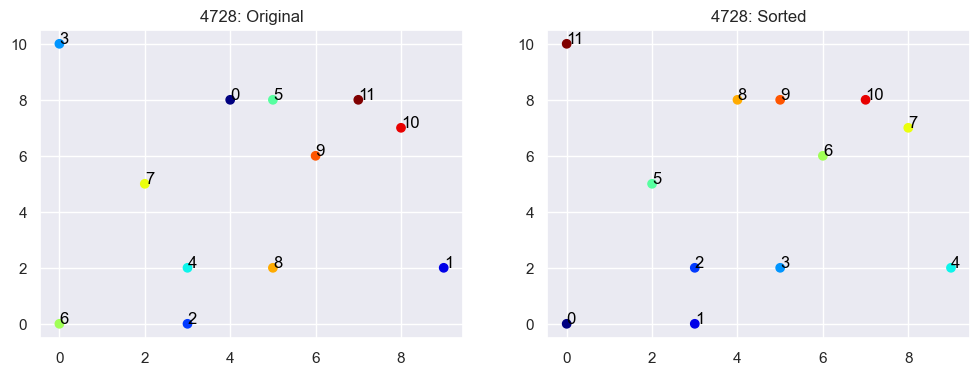

In [ ]:
idx = np.random.choice(range(X.shape[0]), 1, replace=False)[0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(X[idx][:,1], X[idx][:,0], c=range(12), cmap="jet")
# Add number to each point
for i in range(12):
    plt.text(X[idx][i,1], X[idx][i,0], str(i), fontsize=12, color="black")
plt.title(f"{idx}: Original")

plt.subplot(122)
plt.scatter(X_sorted[idx][:,1], X_sorted[idx][:,0], c=range(12), cmap="jet")
# Add number to each point
for i in range(12):
    plt.text(X_sorted[idx][i,1], X_sorted[idx][i,0], str(i), fontsize=12, color="black")
plt.title(f"{idx}: Sorted")

In [ ]:
np.save("X.npy", X_sorted)

Create dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class TracksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, tracks, difficulties):
        self.tracks = tracks
        self.difficulties = difficulties

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, index):
        x = TF.to_tensor(self.tracks[index])
        y = torch.tensor(self.difficulties[index])
        return x, y

In [116]:
# Load data
X = np.load("X.npy")
returns = np.load("returns.npy").mean(axis=1).reshape(-1,1)
Y = np.load("complexities.npy")

X.shape, Y.shape

((20000, 12, 2), (20000,))

In [107]:
# Scale complexities to 0-10
Y = (Y/Y.max()*10).astype(np.int32)

# Scale returns to 0-10
returns = (returns/returns.max()*10).astype(np.float32).round(0)

# Invert returns
returns = np.abs(10 - returns)

Y = Y.reshape(-1,1)

In [23]:
X = np.load("X_30k.npy")
Y = np.load("complexities_30k.npy")
Y = Y.reshape(-1,1)
returns = np.load("returns_30k.npy")

# Rescale Y to 0-10
Y = (Y/Y.max()*10).astype(np.float32).round(0)

X.shape, Y.shape, returns.shape

((30000, 12, 2), (30000, 1), (30000, 5))

In [9]:
X.min(), X.max(), Y.min(), Y.max()

(0.0, 11.0, 0.0, 10.0)

In [174]:
# Generate grids from points in X
grids = []

for i in range(X.shape[0]):
    x = X[i][:,0]
    y = X[i][:,1]
    grid = np.zeros((12,12))
    for j in range(12):
        grid[int(x[j]), int(y[j])] = 1
    grids.append(grid)

X = np.array(grids).astype(np.float32)

In [175]:
X.shape

(30000, 12, 12)

In [10]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# X_train = np.expand_dims(X_train, axis=-1)
#Y_train = np.expand_dims(Y_train, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)
#Y_val = np.expand_dims(Y_val, axis=-1)

# Create datasets
train_dataset = TracksDataset(X_train, Y_train)
val_dataset = TracksDataset(X_val, Y_val)

## Train VAE
Based on https://github.com/sksq96/pytorch-vae/blob/master

In [11]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2, bias=False)  # Two outputs for mean and variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim//2, bias=False),  # Add conditional input
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim - 1),  # Remove conditional input
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        # Encode
        z_params = self.encoder(x)
        mu = z_params[:, :latent_dim]
        logvar = z_params[:, latent_dim:]
        z = self.reparameterize(mu, logvar)

        # Concatenate the last element of x with z
        z = torch.cat([z, x[:,-1].unsqueeze(1)], dim=-1)
        
        # Decode
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [12]:
# Loss function
def loss_function(x_hat, x, mu, logvar):

    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_divergence

In [13]:
# Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [30]:
def train_vae(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, early_stopping={'patience': 5, 'min_delta': 0.001}):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True, min_lr=1e-6)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for x, y in train_loader:
            optimizer.zero_grad()

            # Flatten the input data if it's not already flattened
            x = x.view(x.size(0), -1)
            x = x.to(device)

            y = y.view(y.size(0), -1)
            y = y.to(device)

            xy = torch.cat((x, y), dim=-1)

            x_hat, mu, logvar = model(xy)
            loss = loss_function(x_hat, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.view(x.size(0), -1)
                x = x.to(device)

                y = y.view(y.size(0), -1)
                y = y.to(device)

                xy = torch.cat((x, y), dim=-1)

                x_hat, mu, logvar = model(xy)
                loss = loss_function(x_hat, x, mu, logvar)

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.4f}, val_loss: {val_loss:.4f}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break
        
        scheduler.step(val_loss)

    print('Training finished.')

    return loss_history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

input_dim = 12*2 + 1  # 12 control points (x,y) + 1 conditional input
hidden_dim = 256
latent_dim = 8
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device)

print(vae_model)
print(f'The model has {count_parameters(vae_model):,} trainable parameters')

batch_size = 32
num_epochs = 2_000
early_stopping = {'patience': 15, 'min_delta': 0.05}

# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train VAE
loss_history = train_vae(vae_model,
                        train_loader,
                        val_loader,
                        num_epochs=num_epochs,
                        learning_rate=1e-3,
                        early_stopping=early_stopping)

Device: cuda
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=False)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=16, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=24, bias=True)
  )
)
The model has 81,304 trainable parameters
Epoch [1/2000], train_loss: 100.8655, val_loss: 71.1341
Epoch [2/2000], train_loss: 65.5103, val_loss: 61.5398
Epoch [3/2000], train_loss: 59.6421, val_loss: 58.2892
Epoch [4/2000], train_loss: 55.7629, val_loss: 55.4205
Epoch [5/2000], train_loss: 53.0246, val_loss: 52.5222
Epoch [6/2000], train_loss: 51.1752, val_loss: 50.1994
Epoch [7/2000], train_loss: 49.4252, val_loss: 49.6934
Epoch [8/2000], train_loss: 48.1080, val_loss: 47.8061
Epo

(20.0, 90.0)

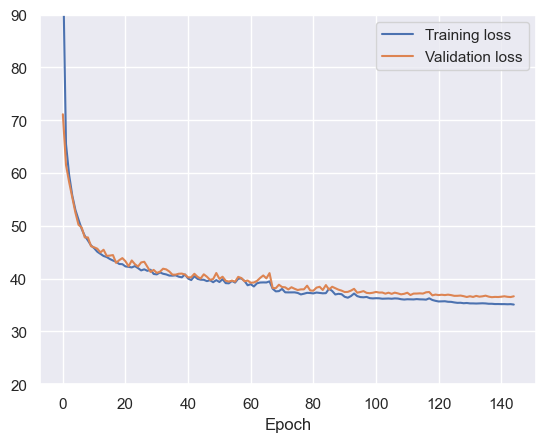

In [31]:
# Plot training and validation loss
plt.plot(loss_history['train_loss'], label="Training loss")
plt.plot(loss_history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(20,90)

In [ ]:
# Save VAE model
torch.save(vae_model.state_dict(), f"models/vae_points_h={hidden_dim}_z={latent_dim}_20k_returns.pt")

In [32]:
# input_dim = 12 * 2 + 1
# hidden_dim = 256
# latent_dim = 12
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load VAE model
# vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device) # GPU
# vae_model.load_state_dict(torch.load(f"models/vae_points_h={2048}_z={latent_dim}_30k.pt"))
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=False)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=16, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=24, bias=True)
  )
)

In [53]:
control_points//30, x

(array([[ 0.,  6.],
        [ 1.,  3.],
        [ 1.,  5.],
        [ 3.,  4.],
        [ 4.,  4.],
        [ 4.,  5.],
        [ 6.,  4.],
        [ 6.,  5.],
        [ 6.,  5.],
        [ 7.,  1.],
        [10.,  2.],
        [10.,  8.]], dtype=float32),
 tensor([[ 0.,  6.,  1.,  3.,  1.,  5.,  3.,  4.,  4.,  4.,  4.,  5.,  6.,  4.,
           6.,  5.,  6.,  5.,  7.,  1., 10.,  2., 10.,  8.]], device='cuda:0'))

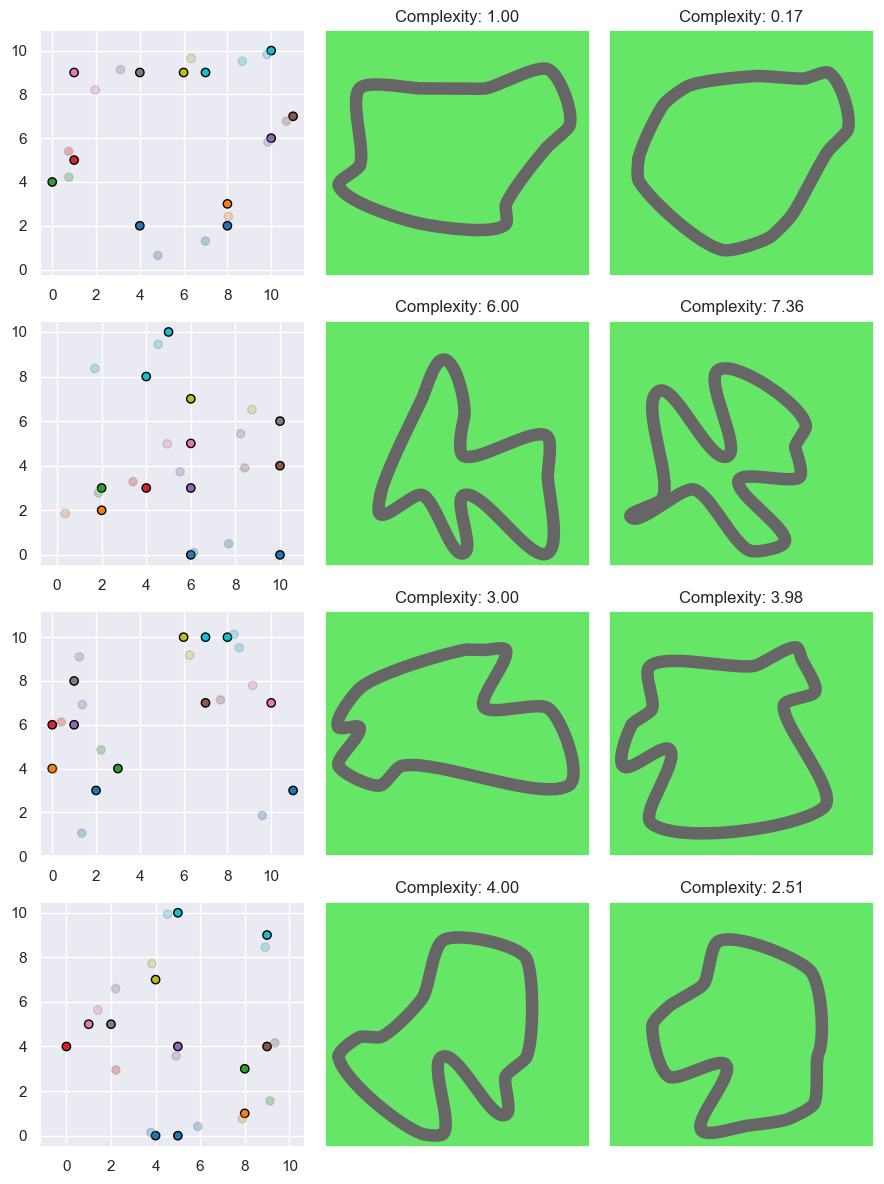

In [65]:
n_images = 4

plt.figure(figsize=(9, int(n_images*3)))

for i in range(n_images):
    j = np.random.randint(0, X_val.shape[0])
    x = val_dataset[j][0]
    y = val_dataset[j][1]
    control_points, x_, y_ = get_track(control_points=x.cpu().squeeze()*30, np_random=np_random)
    track = np.array([x_, y_]).T
    x = x.view(1, -1).to(device)
    y = y.view(1, -1).to(device)
    xy = torch.cat((x, y), dim=-1)
    recon_x, _, _ = vae_model.to(device)(xy)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze()
    recon_x = recon_x.reshape(12,2).astype(np.float32)
    control_points_recon, x_recon, y_recon = get_track(control_points=recon_x*30, np_random=np_random)
    track_recon = np.array([x_recon, y_recon]).T
    complexity_recon = complexity(track_recon)['complexity']/0.25*10

    # Plot original and reconstructed points
    plt.subplot(4,3,1+3*i)
    plt.scatter(x.cpu().squeeze().reshape(12,2)[:,1], x.cpu().squeeze().reshape(12,2)[:,0], cmap="tab10", edgecolor="black", c=range(12))
    plt.scatter(recon_x[:,1], recon_x[:,0], cmap="tab10", edgecolor="gray", alpha=0.3, c=range(12))
    # Equal axis
    plt.axis('equal')
    # Same ticks
    plt.xticks(np.arange(0, 11, 2))

    # Plot number for every point
    # for p in range(12):
    #     plt.text(x.cpu().squeeze().reshape(12,2)[p,1], x.cpu().squeeze().reshape(12,2)[p,0], str(p), fontsize=10, color="black")

    # Plot original track
    plt.subplot(4,3,1+3*i+1)
    plot_track(track)
    plt.grid()
    plt.title(f"Complexity: {y.item():.2f}")

    # Plot reconstructed track
    plt.subplot(4,3,1+3*i+2)
    plot_track(track_recon)
    plt.grid()
    plt.title(f"Complexity: {complexity_recon:.2f}")

plt.tight_layout()

__________

Analyze latent space

In [68]:
# Encode X
XY = torch.cat([torch.tensor(X).view(-1, 24).float(), torch.tensor(Y).view(-1, 1).float()], dim=-1).to(device)
z_params = vae_model.encoder(XY)
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
z = vae_model.reparameterize(mu, logvar).to('cpu').detach().numpy()

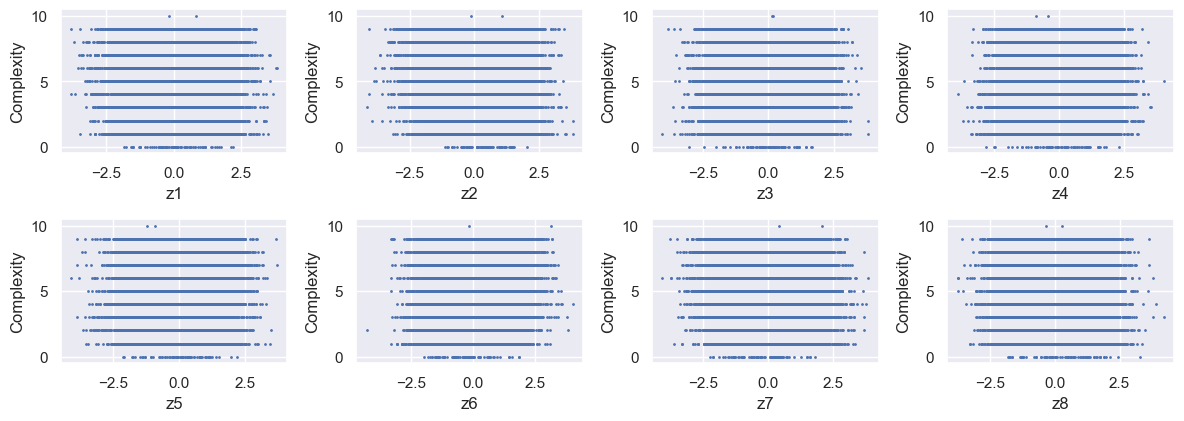

In [69]:
# Plot latent variables against complexity
plt.figure(figsize=(12,6))

for i in range(latent_dim):
    plt.subplot(3, 4, i+1)
    plt.scatter(z[:,i], Y, s=1)
    plt.xlabel(f"z{i+1}")
    plt.ylabel("Complexity")
plt.tight_layout()

Calculate complexity of reconstructed tracks

In [ ]:
complexities_hat = []

for i in range(X.shape[0]):
    control_points, x, y = get_track(X_hat[i]*30, np_random=np_random)
    p = np.array(list(zip(x, y)))
    complexities_hat.append(complexity(p)['complexity'])

    print(f"Progress: {i+1}/{X_hat.shape[0]}", end="\r")

complexities_hat = np.array(complexities_hat)

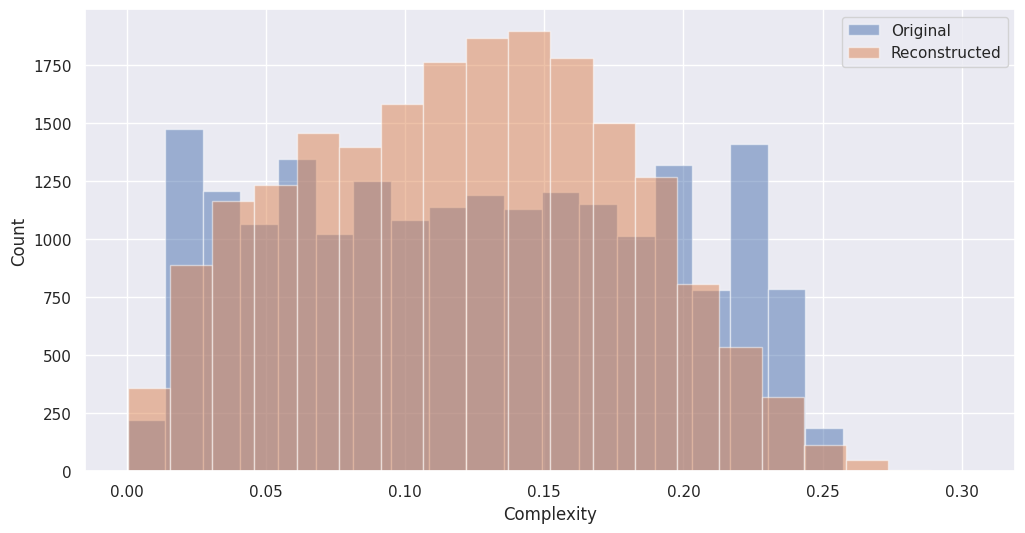

In [ ]:
# Plot a histogram of the original and reconstructed complexities
plt.figure(figsize=(12,6))

plt.hist(complexities, bins=20, alpha=0.5, label="Original")
plt.hist(complexities_hat, bins=20, alpha=0.5, label="Reconstructed")

plt.xlabel("Complexity")
plt.ylabel("Count")
plt.legend()

plt.show()

6359


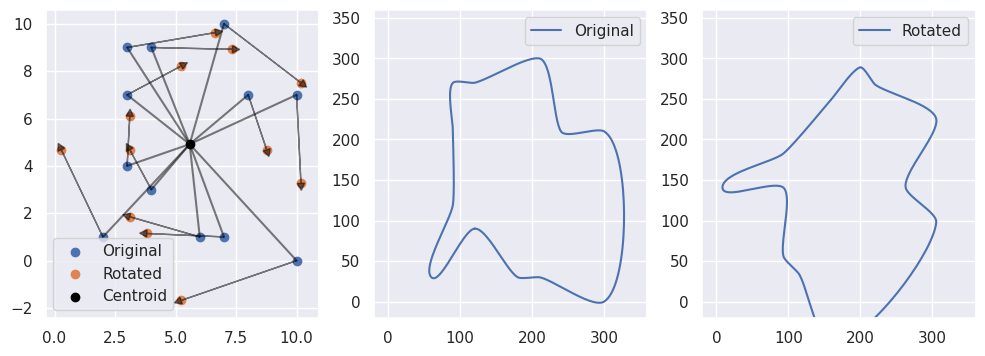

In [ ]:
idx = np.random.choice(range(X.shape[0]), 1, replace=False)[0]
print(idx)

# Rotate the points of X[idx] around the centroid
centroid = X[idx].mean(axis=0)
angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
X_rotated = np.dot(X[idx] - centroid, R) + centroid

plt.figure(figsize=(12,4))

plt.subplot(131)
# Plot the original and rotated points
plt.scatter(X[idx][:,0], X[idx][:,1], label="Original")
plt.scatter(X_rotated[:,0], X_rotated[:,1], label="Rotated")

plt.scatter(centroid[0], centroid[1], color="black", label="Centroid")

# Plot lines from the centroid to each point
for i in range(12):
    plt.plot([centroid[0], X[idx][i,0]], [centroid[1], X[idx][i,1]], color="black", alpha=0.5)
    #plt.plot([centroid[0], X_rotated[i,0]], [centroid[1], X_rotated[i,1]], color="black", alpha=0.5)

# Plot arrows from the original to the rotated points
for i in range(12):
    plt.arrow(X[idx][i,0], X[idx][i,1], X_rotated[i,0]-X[idx][i,0], X_rotated[i,1]-X[idx][i,1], color="black", alpha=0.5, head_width=0.3, head_length=0.3)

plt.legend()

plt.subplot(132)
# Plot the original and rotated tracks
control_points, x, y = get_track(X[idx]*30, np_random=np_random)
plt.plot(x, y, label="Original")
plt.xlim(-20,360)
plt.ylim(-20,360)
plt.legend()

plt.subplot(133)
control_points, x, y = get_track(X_rotated*30, np_random=np_random)
plt.plot(x, y, label="Rotated")
plt.xlim(-20,360)
plt.ylim(-20,360)
plt.legend()


In [ ]:
# Convert to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

# Convert to cartesian coordinates
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

X_rotated_polar = np.array([cart2pol(x, y) for x, y in X_rotated])

# Sort the points by the radius
X_rotated = X_rotated[X_rotated_polar[:,0].argsort()]

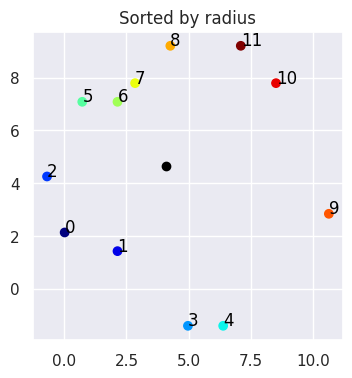

In [ ]:
# Plot points
plt.figure(figsize=(4,4))
plt.scatter(X_rotated[:,0], X_rotated[:,1], c=range(12), cmap="jet")

for i in range(12):
    plt.text(X_rotated[i,0], X_rotated[i,1], str(i), fontsize=12, color="black")
plt.title("Sorted by radius")
plt.scatter(centroid[0], centroid[1], color="black", label="Centroid")

________________________________________

In [160]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [162]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [254]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels + 1, 24, kernel_size=3, stride=1),  # Add conditional input
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim + 1, h_dim)  # Add conditional input
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 48, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 24, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, y):
        y = y.reshape((y.shape[0],1,1,1)).to(device)
        y = torch.ones(x.shape).to(device)*y
        t = torch.cat((x,y),dim=1)
        h = self.encoder(t)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x, y):
        z, mu, logvar = self.encode(x, y)
        y = y.to(device)
        z = torch.cat((z,y),dim=1)
        z = self.decode(z)
        return z, mu, logvar

In [255]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

def train(vae, data, epochs=50, bs=32):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            recon_x, mu, logvar = vae(x, y)
            loss, bce, kld = loss_fn(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
            print(to_print, end="\r")
        print()

In [256]:
vae = VAE(z_dim=64).to(device) # GPU

data = DataLoader(train_dataset, batch_size=32, shuffle=True)

train(vae, data, epochs=100)

/home/zapata/.local/share/virtualenvs/curriculum_learning_ws-qGcE4JgX/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 29.353 29.298 0.056
Epoch[2/100] Loss: 29.310 29.274 0.036
Epoch[3/100] Loss: 26.460 26.380 0.080
Epoch[4/100] Loss: 23.706 23.583 0.123
Epoch[5/100] Loss: 20.414 20.266 0.148
Epoch[6/100] Loss: 17.640 17.482 0.158
Epoch[7/100] Loss: 16.965 16.800 0.165
Epoch[8/100] Loss: 15.341 15.172 0.169
Epoch[9/100] Loss: 14.336 14.151 0.184
Epoch[10/100] Loss: 13.663 13.482 0.181
Epoch[11/100] Loss: 13.064 12.881 0.184
Epoch[12/100] Loss: 12.969 12.786 0.184
Epoch[13/100] Loss: 11.527 11.346 0.180
Epoch[14/100] Loss: 11.601 11.426 0.175
Epoch[15/100] Loss: 10.021 9.842 0.1791
Epoch[16/100] Loss: 10.536 10.355 0.182
Epoch[17/100] Loss: 9.294 9.112 0.18282
Epoch[18/100] Loss: 9.412 9.224 0.18782
Epoch[19/100] Loss: 9.823 9.645 0.17881
Epoch[20/100] Loss: 9.145 8.960 0.18586
Epoch[21/100] Loss: 9.245 9.064 0.18281
Epoch[22/100] Loss: 7.671 7.493 0.17884
Epoch[23/100] Loss: 7.462 7.287 0.17574
Epoch[24/100] Loss: 6.926 6.742 0.18521
Epoch[25/100] Loss: 6.897 6.715 0.18277
Epoch[26/

In [ ]:
# Save VAE model
torch.save(vae.state_dict(), f"vae_{IMG_SIZE}x{IMG_SIZE}_2.pt")

In [ ]:
# Load VAE model
vae = VAE(z_dim=64).to(device) # GPU
vae.load_state_dict(torch.load(f"vae_{IMG_SIZE}x{IMG_SIZE}_4.pt"))

<All keys matched successfully>

In [257]:
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(2, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=65, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 48, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(48, 32, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(24, 1, kernel_size=(3, 3), stride=(1, 1))
    (8): Sigmoid()
  )
)

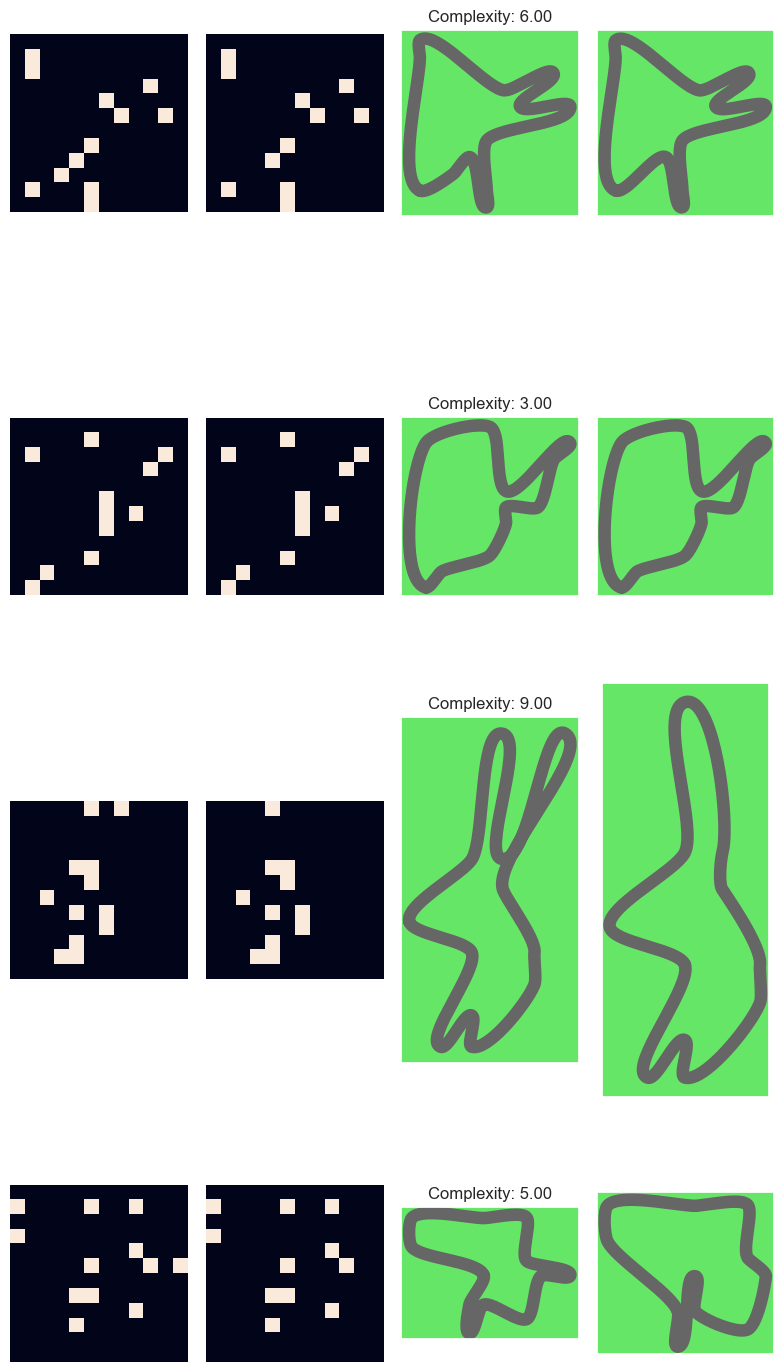

In [277]:
# Plot reconstruction

n_images = 4

plt.figure(figsize=(8,int(4*4)))

for i in range(n_images):
    j = np.random.randint(0, X_val.shape[0])
    x = val_dataset[j][0].unsqueeze(0).to(device)
    y = val_dataset[j][1].unsqueeze(0).to(device)
    recon_x, _, _ = vae(x, y)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze().round(0)

    plt.subplot(n_images,4,1+4*i)
    plt.imshow(x.cpu().squeeze())
    plt.axis('off')
    plt.gca().invert_yaxis()

    plt.subplot(n_images,4,1+4*i+1)
    plt.imshow(recon_x)
    plt.axis('off')
    plt.gca().invert_yaxis()

    plt.subplot(n_images,4,1+4*i+2)
    # Get coordinates of pixels with value 1
    x_, y_ = np.where(x.cpu().numpy().squeeze() == 1)
    # Create track from coordinates
    control_points, x_, y_ = get_track(control_points=np.array(list(zip(x_, y_)))*30)
    track = np.array([x_, y_]).T
    plot_track(track)
    plt.axis('equal')
    # Set aspect of the plot to be equal
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"Complexity: {y.item():.2f}")

    plt.subplot(n_images,4,1+4*i+3)
    # Get coordinates of pixels with value 1
    x_, y_ = np.where(recon_x == 1)
    # Create track from coordinates
    control_points, x_, y_ = get_track(control_points=np.array(list(zip(x_, y_)))*30)
    track = np.array([x_, y_]).T
    plot_track(track)
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()


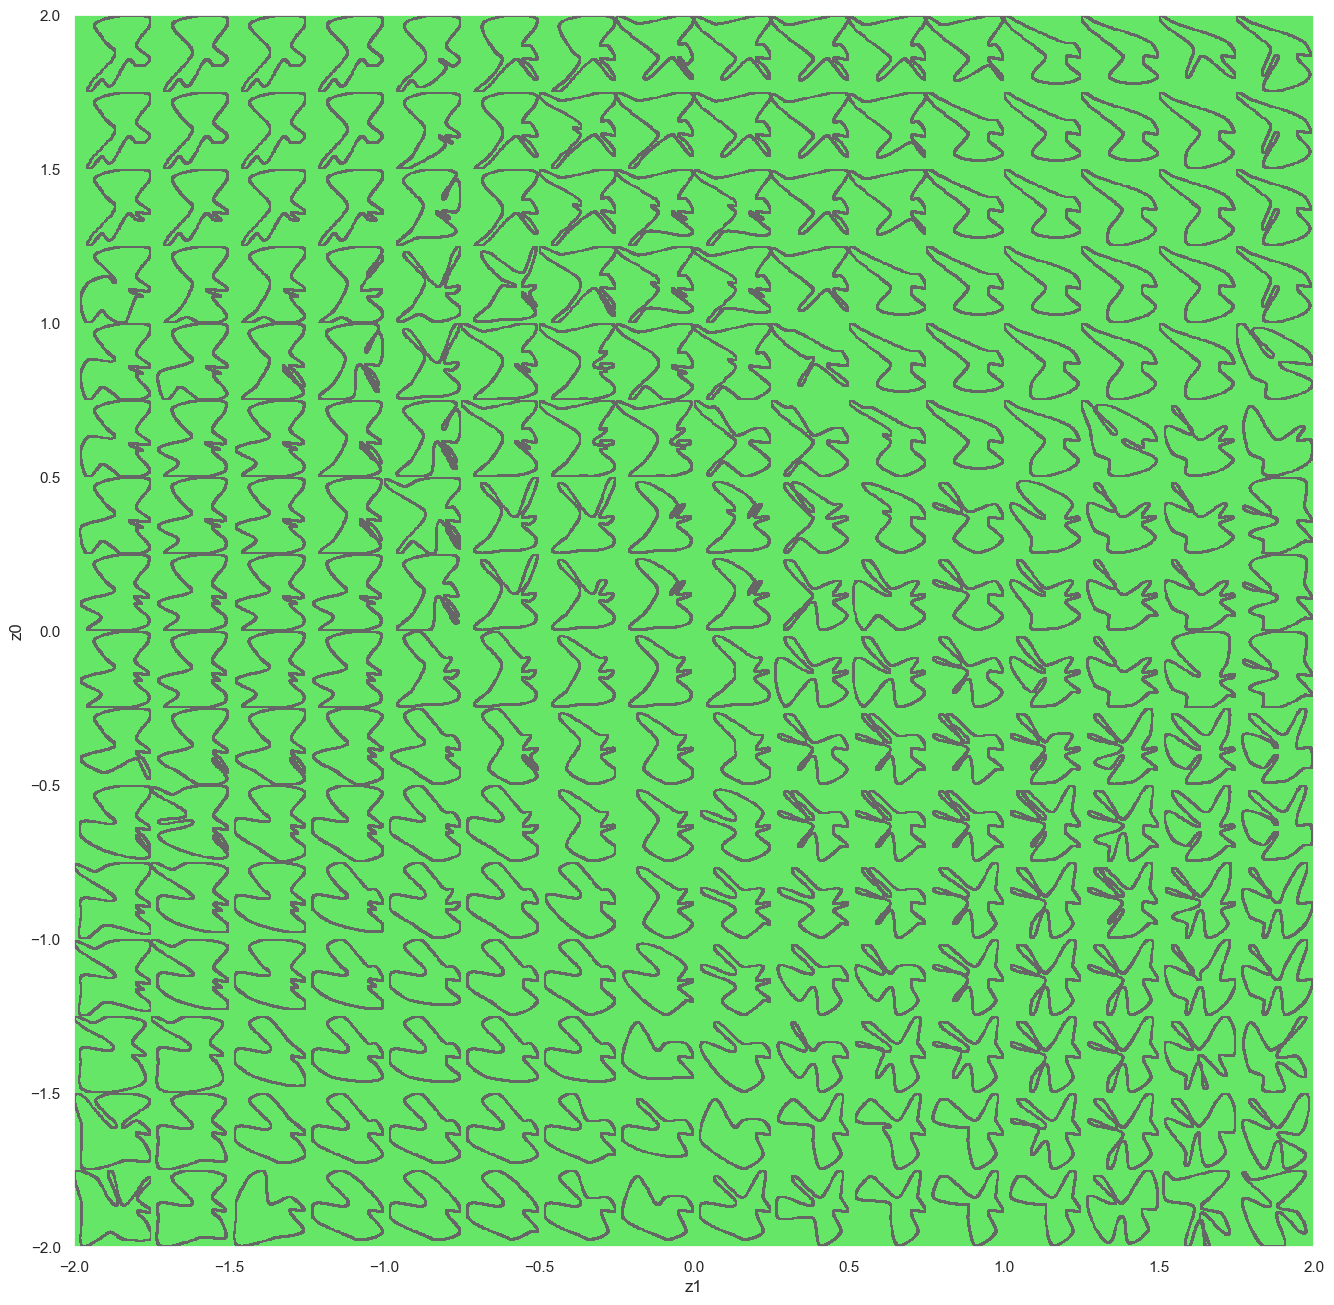

In [278]:
latent_dim = 64

# Generate vector with random values
z_ = np.random.rand(1, latent_dim)

# Track complexity (0-10, 0 being the simplest)
complexity_ = 1
complexity_ = torch.tensor([complexity_]).to(device).float()

# Number of tracks to plot in each dimension
n = 16

# Latent variables to vary
c0 = 0  
c1 = 1

# Limits
r0 = (-2, 2)
r1 = (-2, 2)

img_size = (84, 84)
w = img_size[0]
img = np.zeros((n*w, n*w)).astype(np.uint8)

# Create new color map
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

grass_green = np.array([102/255, 230/255, 102/255, 1])
road_gray = np.array([0.4, 0.4, 0.4, 1])
newcolors = np.array([grass_green, road_gray])
new_cmp = ListedColormap(newcolors)

plt.figure(figsize=(16,16))
# Variate the first element of the vector
for i, x in enumerate(np.linspace(*r0, n)):
    for j, y in enumerate(np.linspace(*r1, n)):
        z = z_.copy()
        z[0,c0] = x
        z[0,c1] = y
        z = torch.tensor(z).to(device).ravel().float()
        z = torch.cat([z, complexity_], dim=-1)
        z = z.view(1, -1)
        # Reconstruct image using VAE
        recon_x = vae.decode(z).to('cpu').detach().numpy().squeeze().round(0)
        x_, y_ = np.where(recon_x == 1)
        control_points, x_, y_ = get_track(control_points=np.array(list(zip(x_, y_)))*30)
        track = np.array([x_, y_]).T
        track_img = get_image(track, img_size=img_size)

        # Dilation
        kernel = np.ones((3,3),np.uint8)
        track_img = cv2.dilate(track_img, kernel, iterations=1)
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = track_img.astype(np.uint8)

plt.imshow(img, cmap=new_cmp, extent=[*r1, *r0], aspect="auto")
plt.grid(False)
plt.xlabel(f"z{c1}")
plt.ylabel(f"z{c0}")
plt.show()

#### Reconstruct images using variational autoencoder (VAE)

Reconstruct randomly sampled vector from latent space

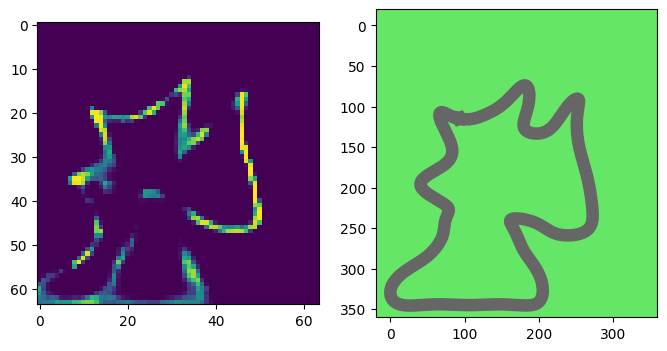

In [ ]:
# Reconstruct image from latent space vector
noise = torch.randn(1, 24).to(device)
recon_x = vae.decode(noise).to('cpu').detach().numpy().squeeze()
#Get control points from image
recon_x = (recon_x*255).astype(np.uint8)
control_points = get_control_points_from_image(recon_x)
x, y = control_points[:,0], control_points[:,1]

# Plot track & image
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(recon_x)

plt.subplot(122)
plot_track(np.array([x, y]).T)
plt.gca().invert_yaxis()

___________

### Visualize latent space

Histogram of latent variables

In [ ]:
# Encode data
z_params = vae_model.encoder(torch.tensor(X).float().to(device).view(-1, 24)).to(device)
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
X_encoded = vae_model.reparameterize(mu, logvar)

(array([3.000e+00, 2.300e+01, 9.900e+01, 2.500e+02, 5.300e+02, 1.009e+03,
        1.666e+03, 2.396e+03, 2.893e+03, 3.011e+03, 2.621e+03, 2.232e+03,
        1.575e+03, 9.360e+02, 4.320e+02, 2.070e+02, 8.000e+01, 2.700e+01,
        9.000e+00, 1.000e+00]),
 array([-3.70834994, -3.32242727, -2.93650436, -2.55058169, -2.16465878,
        -1.77873611, -1.39281332, -1.00689054, -0.62096775, -0.23504494,
         0.15087783,  0.53680062,  0.92272341,  1.3086462 ,  1.69456899,
         2.08049178,  2.46641445,  2.85233736,  3.23826003,  3.62418294,
         4.01010561]),
 <BarContainer object of 20 artists>)

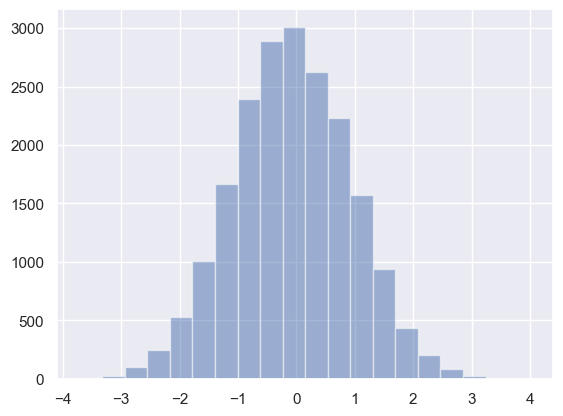

In [ ]:
i = 1
plt.hist(X_encoded[:,i].detach().cpu().numpy(), bins=20, alpha=0.5)

2d plot showing the distribution of tracks in the latent space

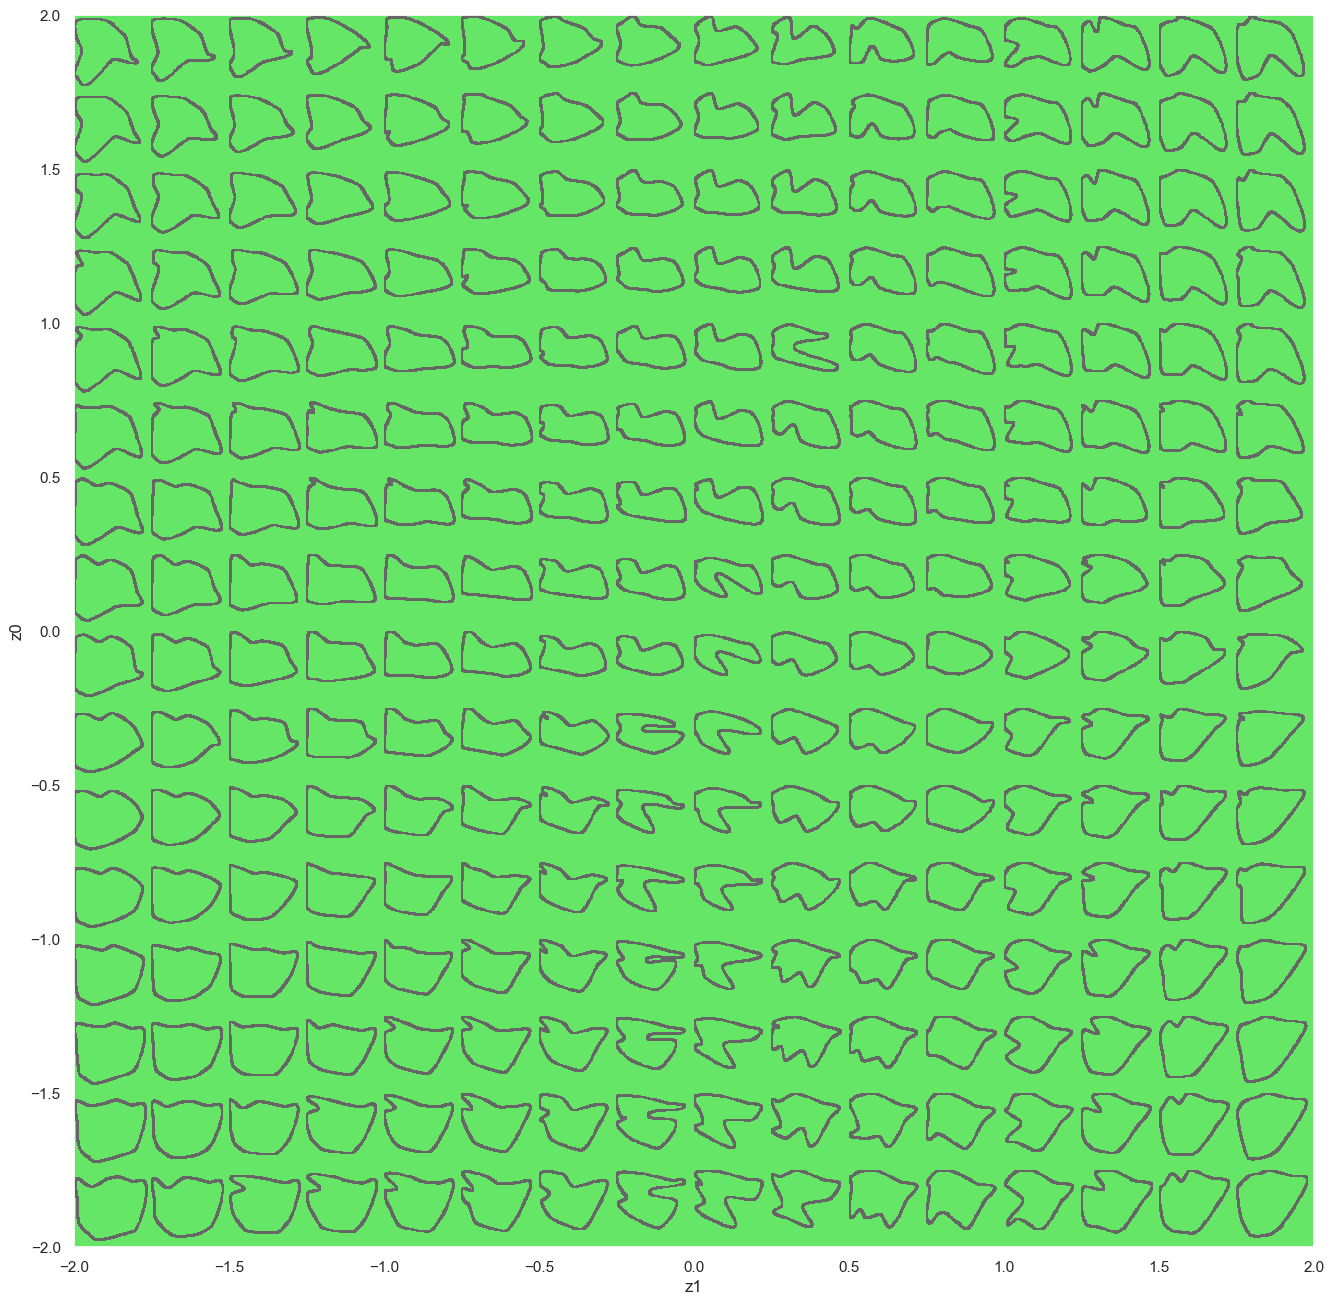

In [36]:
latent_dim = 8

# Generate vector with random values
z_ = np.random.rand(1, latent_dim)

# Track complexity (0-10, 0 being the simplest)
complexity_ = 0
complexity_ = torch.tensor([complexity_]).to(device).float()

# Number of tracks to plot in each dimension
n = 16

# Latent variables to vary
c0 = 0  
c1 = 1

# Limits
r0 = (-2, 2)
r1 = (-2, 2)

img_size = (84, 84)
w = img_size[0]
img = np.zeros((n*w, n*w)).astype(np.uint8)

# Create new color map
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

grass_green = np.array([102/255, 230/255, 102/255, 1])
road_gray = np.array([0.4, 0.4, 0.4, 1])
newcolors = np.array([grass_green, road_gray])
new_cmp = ListedColormap(newcolors)

plt.figure(figsize=(16,16))
# Variate the first element of the vector
for i, x in enumerate(np.linspace(*r0, n)):
    for j, y in enumerate(np.linspace(*r1, n)):
        z = z_.copy()
        z[0,c0] = x
        z[0,c1] = y
        z = torch.tensor(z).to(device).ravel().float()
        z = torch.cat([z, complexity_], dim=-1)
        # Reconstruct image using VAE
        recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(12,2)
        control_points, x_, y_ = get_track(control_points=recon_x*30, np_random=np_random)
        track = np.array([x_, y_]).T
        track_img = get_image(track, img_size=img_size)
        # Dilation
        kernel = np.ones((3,3),np.uint8)
        track_img = cv2.dilate(track_img, kernel, iterations=1)
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = track_img.astype(np.uint8)

plt.imshow(img, cmap=new_cmp, extent=[*r1, *r0], aspect="auto")
plt.grid(False)
plt.xlabel(f"z{c1}")
plt.ylabel(f"z{c0}")
plt.show()

In [ ]:
# Generate easy grid and hard tracks
easy = 0
hard = 11

# Interpolate between easy and hard difficulty
n = 1000
z_ = np.random.rand(n, latent_dim+1)
z_[:, -1] = np.linspace(easy, hard, n)

tracks = []
for i in range(n):
    z = torch.tensor(z_[i]).to(device).ravel().float()
    recon_x = vae_model.decoder(z)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(12,2).astype(np.int32)
    control_points, x_, y_ = get_track(control_points=recon_x*30, np_random=np_random)
    track = np.array([x_, y_]).T
    track_img = get_image(track, img_size=img_size)
    # Dilation
    kernel = np.ones((3,3),np.uint8)
    track_img = cv2.dilate(track_img, kernel, iterations=1)
    # 3 channels
    track_img = np.stack((track_img,)*3, axis=-1)
    # Replace black by grass green
    track_img[track_img[:,:,0] == 0] = [102, 230, 102]
    # Replace white by road gray
    track_img[track_img[:,:,0] == 1] = [102, 102, 102]
    tracks.append(track_img.astype(np.uint8))

In [ ]:
import imageio
# Create a gif from the images
imageio.mimsave(f'vae_{latent_dim}_latent_space.gif', tracks, duration=250, format="GIF")

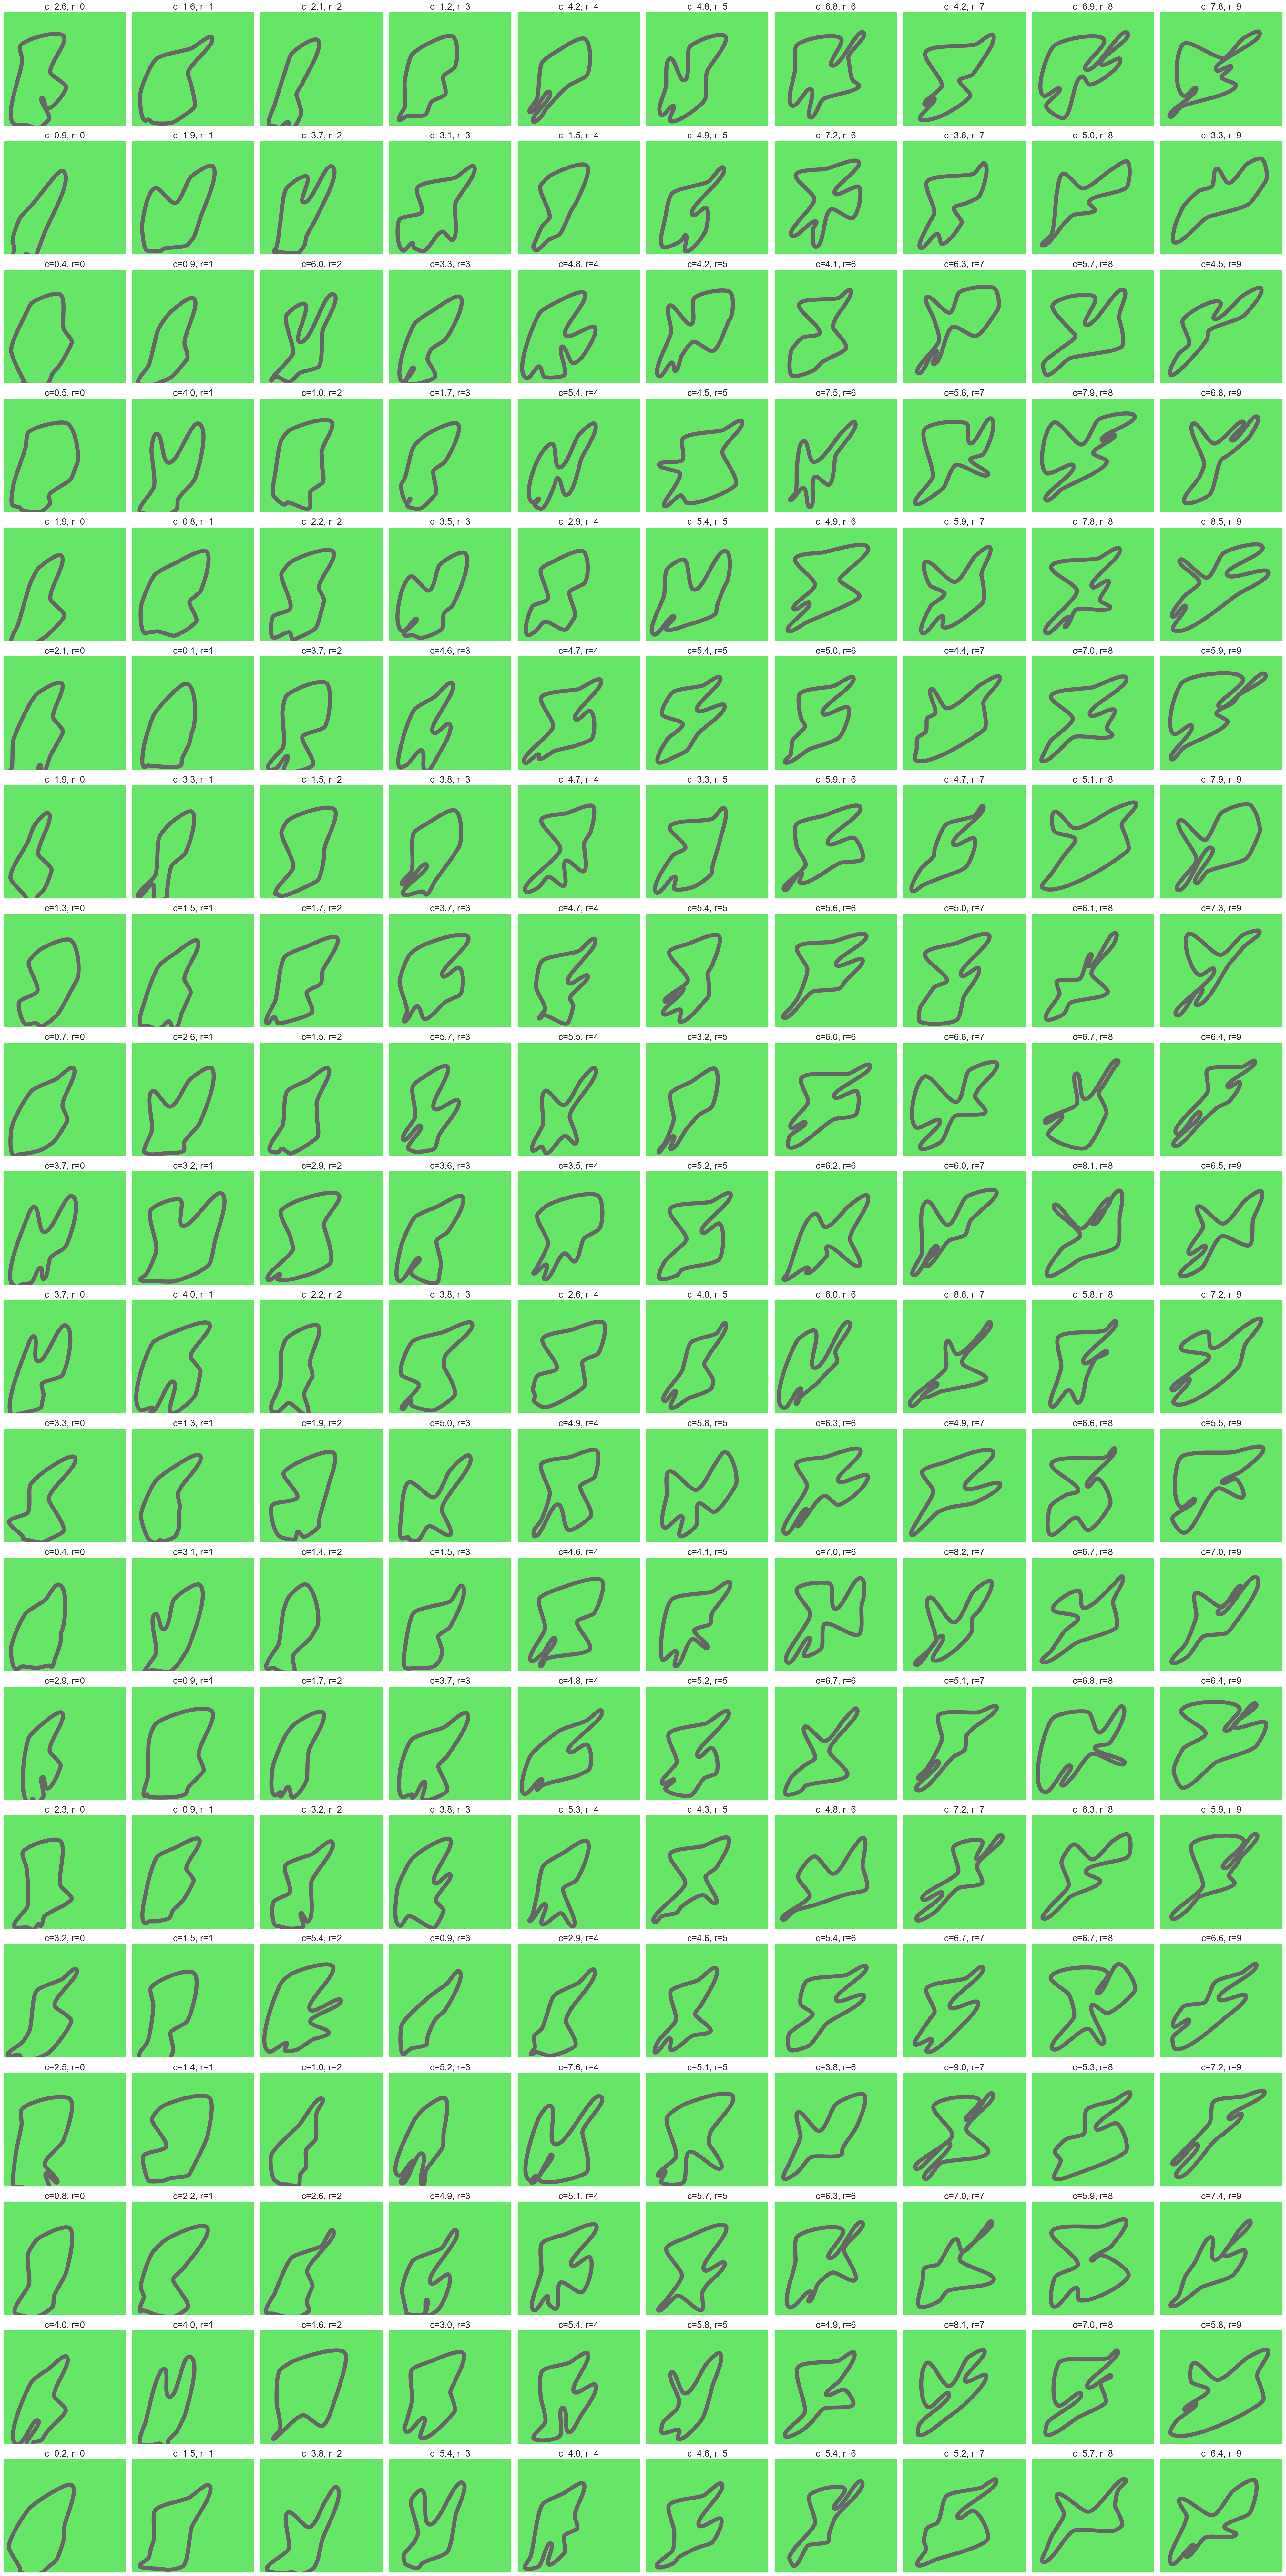

In [66]:
# Plot tracks of increasing complexity
n_complexities = 10
n_tracks = 20
img_size = (84, 84)
w, h = img_size[0], img_size[1]

plt.figure(figsize=(4*n_complexities, 4*n_tracks))

complexities_ = [[] for _ in range(n_tracks)]

for i in range(n_tracks):
    for j, c in enumerate(range(n_complexities)):
        z = np.random.rand(1, latent_dim)
        z = np.append(z, c)
        z = torch.tensor(z).to(device).ravel().float()
        # Reconstruct image using VAE
        recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(12,2)
        control_points, x_, y_ = get_track(control_points=recon_x*30, np_random=np_random)
        track = np.array([x_, y_]).T
        plt.subplot(n_tracks, n_complexities, i*n_complexities+j+1)
        plot_track(track)
        complexity_ = complexity(track)['complexity']
        plt.title(f"c={complexity_/0.25*10:.1f}, r={j}", fontsize=20)
        complexities_[i].append(complexity_)

plt.tight_layout()

(0.0, 11.0)

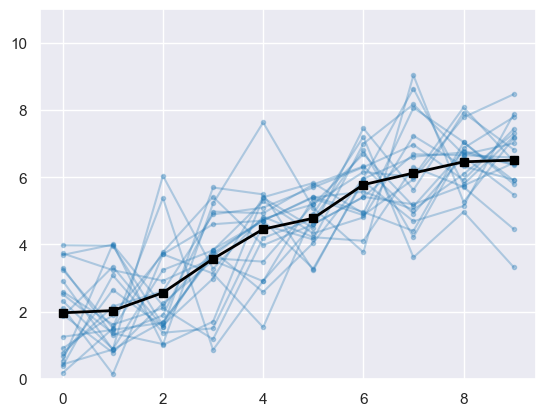

In [67]:
complexities_ = np.array(complexities_)/0.25*10
complexities_mean = np.mean(complexities_, axis=0)

for i in range(n_tracks):
    plt.plot(complexities_[i], marker=".", color="tab:blue", alpha=0.3)

plt.plot(complexities_mean, marker="s", color="black", linewidth=2)

plt.ylim(0,11)

In [ ]:
control_points

array([[  8.315573,  24.322628],
       [ 42.432995,  67.692894],
       [ 88.31414 ,  82.82173 ],
       [ 98.83111 , 247.44519 ],
       [132.57384 ,  90.35503 ],
       [126.02061 , 137.59146 ],
       [147.65575 ,  21.573635],
       [140.29774 , 149.53656 ],
       [168.59854 ,  78.60004 ],
       [177.65462 , 150.85689 ],
       [225.98293 , 203.01068 ],
       [276.00485 , 233.58594 ]], dtype=float32)

Generate tracks using conditional VAE

In [ ]:
# Create 10 bins of complexity from 0 to 0.25
num_bins = 10
bins = np.linspace(0, 0.25, num_bins+1)
bins

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 ])

In [ ]:
num_tracks_per_bin = 5_000

X = []  # Track control points
Y = []  # Complexities

for i in range(num_bins):
    for j in range(num_tracks_per_bin):
        comp = -1
        while (comp < bins[i] or comp > bins[i+1]):
            z = np.random.rand(1, latent_dim)
            z = np.append(z, i)
            z = torch.tensor(z).to(device).ravel().float()
            # Reconstruct image using VAE
            recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(12,2).astype(np.int32)
            control_points, x_, y_ = get_track(control_points=recon_x*30, np_random=np_random)
            track = np.array([x_, y_]).T
            comp = complexity(track)['complexity']
        X.append(recon_x)
        Y.append(comp)

        print(f"Progress: {i*num_tracks_per_bin+j+1}/{num_bins*num_tracks_per_bin}", end="\r")

X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.float32)

In [ ]:
np.save("X_50000_CVAE.npy", X)
np.save("Y_50000_CVAE.npy", Y)

In [ ]:
Y = np.load("Y_50000_CVAE.npy")

In [ ]:
# Scale Y to 0-10
Y = (Y/Y.max()*10).astype(np.float32)
Y = Y.reshape(-1,1)
Y.min(), Y.max()

(0.018269157, 10.0)

(array([1160., 3891., 2267., 2768., 2491., 2487., 2696., 2299., 2844.,
        2166., 2888., 2093., 3030., 1966., 3231., 1757., 3339., 1640.,
        3394., 1593.]),
 array([0.00045672, 0.01293355, 0.02541038, 0.03788721, 0.05036404,
        0.06284088, 0.07531771, 0.08779454, 0.10027137, 0.11274821,
        0.12522504, 0.13770187, 0.1501787 , 0.16265553, 0.17513236,
        0.1876092 , 0.20008603, 0.21256286, 0.22503969, 0.23751652,
        0.24999335]),
 <BarContainer object of 20 artists>)

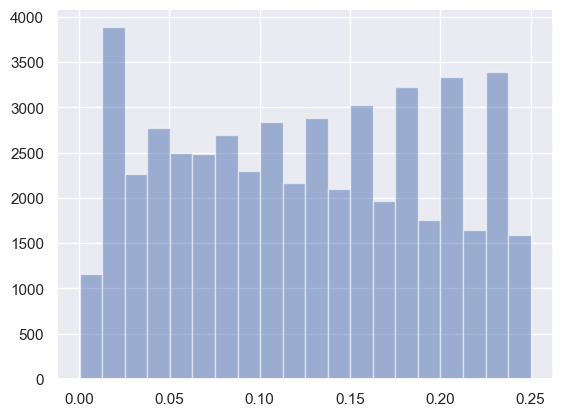

In [ ]:
# Histogram of complexities
plt.hist(Y, bins=20, alpha=0.5)

Data augmentation

3534


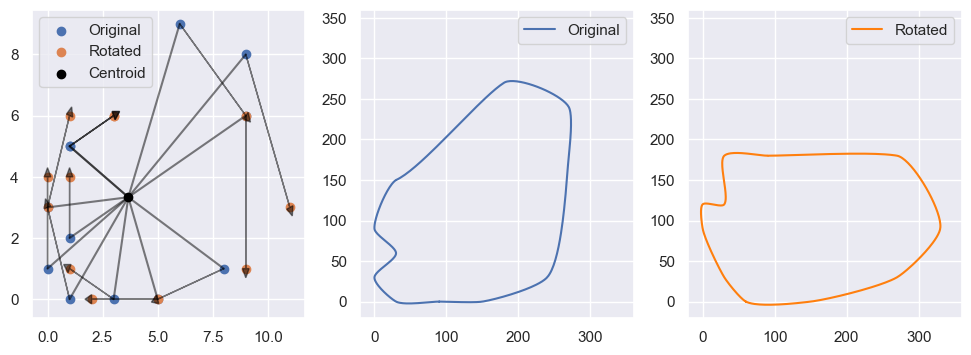

In [ ]:
idx = np.random.choice(range(X.shape[0]), 1, replace=False)[0]
print(idx)

# Rotate the points of X[idx] around the centroid
centroid = X[idx].mean(axis=0)
angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
X_rotated = np.dot(X[idx] - centroid, R) + centroid
# Clip to 0-11
X_rotated = np.clip(X_rotated, 0, 11).round(0)

plt.figure(figsize=(12,4))

plt.subplot(131)
# Plot the original and rotated points
plt.scatter(X[idx][:,0], X[idx][:,1], label="Original")
plt.scatter(X_rotated[:,0], X_rotated[:,1], label="Rotated")

plt.scatter(centroid[0], centroid[1], color="black", label="Centroid")

# Plot lines from the centroid to each point
for i in range(12):
    plt.plot([centroid[0], X[idx][i,0]], [centroid[1], X[idx][i,1]], color="black", alpha=0.5)
    #plt.plot([centroid[0], X_rotated[i,0]], [centroid[1], X_rotated[i,1]], color="black", alpha=0.5)

# Plot arrows from the original to the rotated points
for i in range(12):
    plt.arrow(X[idx][i,0], X[idx][i,1], X_rotated[i,0]-X[idx][i,0], X_rotated[i,1]-X[idx][i,1], color="black", alpha=0.5, head_width=0.3, head_length=0.3)

plt.legend()

plt.subplot(132)
# Plot the original and rotated tracks
control_points, x, y = get_track(X[idx]*30, np_random=np_random)
plt.plot(x, y, label="Original")
plt.xlim(-20,360)
plt.ylim(-20,360)
plt.legend()

plt.subplot(133)
control_points, x, y = get_track(X_rotated*30, np_random=np_random)
plt.plot(x, y, color="tab:orange", label="Rotated")
plt.xlim(-20,360)
plt.ylim(-20,360)
plt.legend()


In [ ]:
# Augment data by rotating the points
X_augmented = []
Y_augmented = []

for i in range(X.shape[0]):
    for angle in range(0, 360, 45):
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))
        X_rotated = np.dot(X[i] - centroid, R) + centroid
        X_rotated = np.clip(X_rotated, 0, 11).round(0)  # Clip to 0-11
        X_augmented.append(X_rotated)
        control_points, x, y = get_track(X_rotated*30, np_random=np_random)
        comp = complexity(np.array([x, y]).T)['complexity']      
        Y_augmented.append(Y[i])

    print(f"Progress: {i+1}/{X.shape[0]}", end="\r")

In [ ]:
X_augmented = np.array(X_augmented).astype(np.float32)
Y_augmented = np.array(Y_augmented).astype(np.float32)

In [ ]:
np.save("X_augmented_50000_CVAE.npy", X_augmented)
np.save("Y_augmented_50000_CVAE.npy", Y_augmented)

In [ ]:
Y_augmented = (Y_augmented/Y_augmented.max()*10).astype(np.float32)
Y_augmented = Y_augmented.reshape(-1,1)

In [ ]:
X = X_augmented
Y = Y_augmented

In [ ]:
# Load data
X = np.load("X_augmented_50000_CVAE.npy")
Y = np.load("Y_augmented_50000_CVAE.npy")

OSError: [Errno 127] Key has expired: 'X_augmented_50000_CVAE.npy'

___________

In [ ]:
# Create a gif from the images
import imageio

images = []

rows, cols = range(n), range(n)

# Create a gif from the images of the first column
for row in rows:
#for col in cols:
    col = 191
    #row = 160
    images.append(img[row*w:(row+1)*w, col*w:(col+1)*w]*255)

images = images + images[::-1]

In [ ]:
# Create a gif from the images
imageio.mimsave(f'vae_{latent_dim}_latent_space.gif', images, duration=30, format="GIF")